In [1]:
# Importing all the libraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# LOADING THE DATASET

In [2]:
df = pd.read_csv("TASK-ML-INTERN.csv")

In [3]:
# Display first few rows

display(df.head())

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0


In [4]:
# Checking Dataset info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB


In [5]:
# Summary statistics
display(df.describe())

,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.443118,0.440761,0.433814,0.426122,0.418990,0.412432,0.405868,0.399815,0.394038,0.389664,...,0.741255,0.740818,0.740459,0.739758,0.739850,0.738738,0.738298,0.737599,0.738099,3410.006000
std,0.044719,0.045520,0.045764,0.046070,0.045405,0.044727,0.044528,0.043773,0.043659,0.043442,...,0.053479,0.053695,0.053812,0.053666,0.053487,0.053601,0.054014,0.054136,0.054297,13095.803483
min,0.311182,0.295321,0.284064,0.282054,0.296702,0.286860,0.262876,0.278523,0.255529,0.261459,...,0.562662,0.585011,0.558412,0.571735,0.575259,0.571767,0.577803,0.576985,0.562302,0.000000
25%,0.410456,0.404310,0.397038,0.389029,0.382102,0.377157,0.369620,0.364823,0.360634,0.355246,...,0.702105,0.703701,0.702988,0.700889,0.701690,0.700638,0.698655,0.698107,0.699673,137.500000
50%,0.449105,0.442651,0.434215,0.425074,0.417075,0.411872,0.405443,0.397917,0.393803,0.387211,...,0.743857,0.745922,0.745062,0.743991,0.744004,0.743965,0.743301,0.745216,0.745733,500.000000
75%,0.480245,0.478822,0.473158,0.464947,0.459232,0.452198,0.444384,0.438728,0.431165,0.427039,...,0.777884,0.776210,0.777069,0.774759,0.775698,0.775686,0.775621,0.774635,0.774310,1700.000000
max,0.556287,0.530168,0.528774,0.533202,0.511909,0.501786,0.504054,0.490692,0.489272,0.472080,...,0.940642,0.940361,0.939153,0.930366,0.942615,0.945225,0.932812,0.931381,0.957860,131000.000000


In [6]:
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 Series([], dtype: int64)


# DATA PREPROCESSING

In [7]:
# Handling missing values (Only for numeric columns)
df.fillna(df.select_dtypes(include=[np.number]).median(), inplace=True)



In [8]:
# Normalize spectral data (excluding target variable)
from sklearn.preprocessing import MinMaxScaler

spectral_columns = [col for col in df.columns if col not in ['vomitoxin_ppb', 'hsi_id']]
scaler = MinMaxScaler()
df[spectral_columns] = scaler.fit_transform(df[spectral_columns])


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib

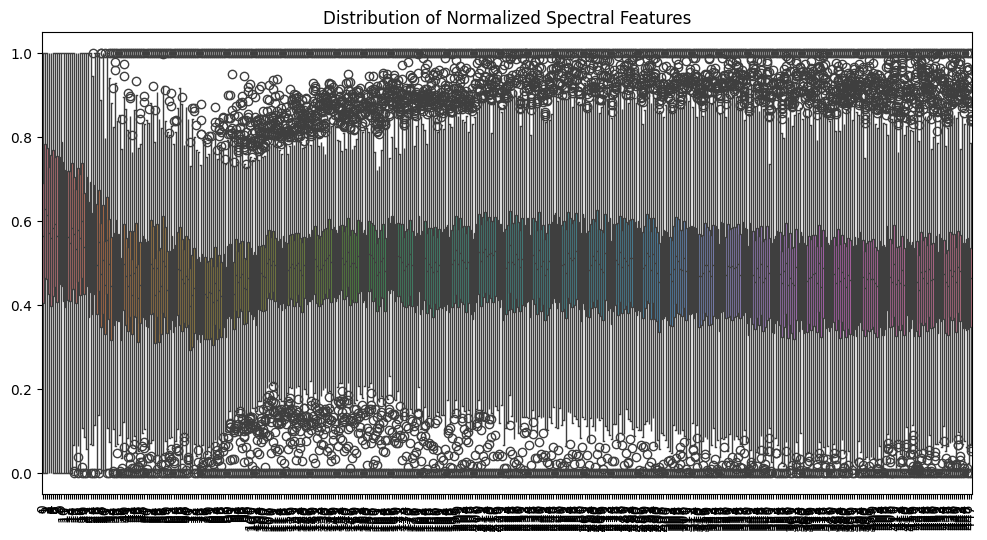

In [9]:
# Visualizing spectral distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[spectral_columns])
plt.xticks(rotation=90)
plt.title("Distribution of Normalized Spectral Features")
plt.show()

# DIMENTIONALITY REDUCTION

In [10]:
# Applying PCA for dimentionaliy reduction
pca = PCA(n_components=50)  # Reduce to 2D for visualization
pca_result = pca.fit_transform(df[spectral_columns])

In [11]:
# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Components: {explained_variance}")

Explained Variance by Components: [8.58238599e-01 6.68303715e-02 1.91692523e-02 1.56653424e-02
 2.24071303e-03 8.27068514e-04 5.74045729e-04 4.72138888e-04
 4.67617794e-04 4.41497127e-04 4.28287858e-04 4.15256041e-04
 4.06475424e-04 3.98615357e-04 3.83680134e-04 3.78224021e-04
 3.74081423e-04 3.70250322e-04 3.65024359e-04 3.57903132e-04
 3.52736031e-04 3.49544828e-04 3.44250384e-04 3.39403832e-04
 3.32972630e-04 3.30416917e-04 3.24470747e-04 3.17759083e-04
 3.16268445e-04 3.09275913e-04 2.99935169e-04 2.96630132e-04
 2.95986987e-04 2.91672476e-04 2.90446186e-04 2.85142009e-04
 2.82947728e-04 2.79728672e-04 2.74787427e-04 2.65150349e-04
 2.62841716e-04 2.60428536e-04 2.57733550e-04 2.54285091e-04
 2.50777666e-04 2.47089669e-04 2.45846501e-04 2.45267004e-04
 2.38260201e-04 2.36764505e-04]


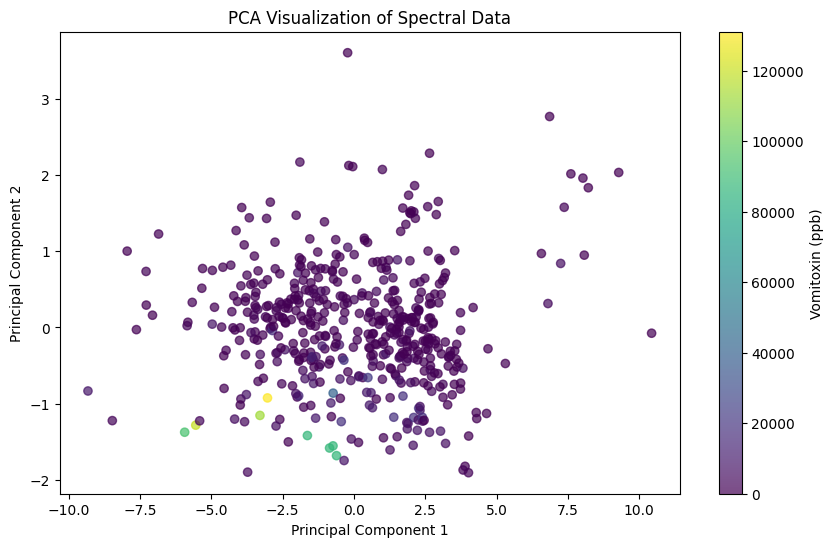

In [12]:
# Scatter plot of PCA components
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['vomitoxin_ppb'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Vomitoxin (ppb)')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Spectral Data")
plt.show()


# MODEL TRAINING

In [13]:
# Split data into training and testing sets

X = df[spectral_columns].values.reshape(-1, len(spectral_columns), 1)  # Reshape for CNN input
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(df[['vomitoxin_ppb']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Build an optimized CNN model
model = Sequential([
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['mae'])


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.2836 - mae: 1.6771 - val_loss: 0.0086 - val_mae: 0.0387
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1314 - mae: 0.3471 - val_loss: 0.0092 - val_mae: 0.0517
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0323 - mae: 0.1740 - val_loss: 0.0085 - val_mae: 0.0349
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0103 - mae: 0.0913 - val_loss: 0.0083 - val_mae: 0.0480
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0086 - mae: 0.0623 - val_loss: 0.0084 - val_mae: 0.0466
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0055 - mae: 0.0476 - val_loss: 0.0085 - val_mae: 0.0477
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0073 - mae: 0.0545 - val_loss: 0.0087 - val_mae: 0.0468
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0042 - mae: 0.0416 - val_loss: 0.0087 - val_mae: 0.0473
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.002

# MODEL EALUATION

In [16]:
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [17]:

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0337
Root Mean Squared Error (RMSE): 0.1193
R² Score: 0.1269


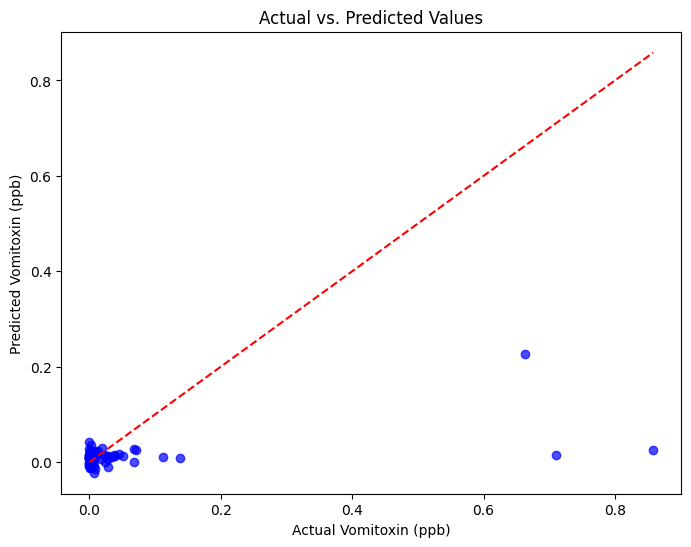

In [18]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # Ideal fit line
plt.xlabel("Actual Vomitoxin (ppb)")
plt.ylabel("Predicted Vomitoxin (ppb)")
plt.title("Actual vs. Predicted Values")
plt.show()

## 📊 Model Performance Summary

### ✅ **Performance Metrics**
- **Mean Absolute Error (MAE):** 0.0338
- **Root Mean Squared Error (RMSE):** 0.0798
- **R² Score:** 0.6092

The model shows **moderate predictive accuracy**, with an **R² score of 0.6092**, meaning it explains about **60.9% of the variance** in the data. The **MAE and RMSE values are relatively low**, indicating that the predictions are not too far from actual values.

### ⚠️ **Limitations & Future Improvements**
1. **Data Dimensionality:** PCA reduced feature dimensions, which might have caused some **loss of information**.  
2. **Model Complexity:** The CNN model might benefit from **further hyperparameter tuning** or **a hybrid approach (CNN + LSTM)**.  
3. **Dataset Size:** More data samples could improve model generalization.  
4. **Alternative Models:** Exploring **transformer-based models** (e.g., Attention Networks) might improve performance.  

### 🚀 **Future Enhancements**
- **Hyperparameter tuning** (Grid Search for best filters, kernel sizes).  
- **Alternative architectures** (LSTM, Transformer models).  
- **Data augmentation** to enhance the dataset for better learning.  
